In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('darkgrid')
idx = pd.IndexSlice # for multi Indexer

In [5]:
import gdown
!gdown --id 1Dy9s5m6icAyWi9eHOLOchPHyadQphu40

Downloading...
From: https://drive.google.com/uc?id=1Dy9s5m6icAyWi9eHOLOchPHyadQphu40
To: /content/final.csv
100% 18.5M/18.5M [00:00<00:00, 113MB/s]


In [6]:
data = pd.read_csv('final.csv')

In [7]:
code_check = data['code'].unique()

In [9]:
from datetime import datetime
# data의 date column의 형식 변환
data.date= data.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d')) 

In [10]:
data = data.set_index(['code','date'])

In [14]:
code_check[0]

60

In [20]:
drop_code = []
# data의 개수가 1113개가 되지 않는 data 제외
for code in code_check:
  if(len(data.loc[code])!=1113):
    drop_code.append(code)

In [21]:
data.drop(drop_code, axis=0, inplace=True)

In [22]:
data.dropna(axis=0, inplace=True)

In [23]:
YEAR = 249 # 주말, 공휴일 제외 날짜 249~252 일

In [24]:
y = (data['ascent_65'] > 0).astype(int) # positive : 1 / negative : 0 
data = data.drop(['ascent_65'], axis=1) # drop 3month ascents

In [ ]:
y.value_counts() 

0    96784
1    82812
Name: ascent_65, dtype: int64

In [27]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=21,
                 test_period_length=3,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique() # date를 받아옴
        days = sorted(unique_dates, reverse=True) # 날짜를 최신-> 오래됨 정렬

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length

            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1

            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])
            

        dates = X.reset_index()[['date']]
       
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx # for making generator

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [28]:
train_period_length = 152 # 약 45주, 11달 63/126
test_period_length = 10 # 약 2주
n_splits = 4 * int(YEAR/test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [40]:
for train_idx, test_idx in cv.split(X=data):
    # Train
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')

    # Test
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')

    df = train.reset_index().append(test.reset_index()) 
    n = len(df)
    assert n == len(df.drop_duplicates()) # row 중복이 있으면 warning 
    
    # train code 별 row 개수 
    print(f" Train : {train.groupby(level='code').size().value_counts().index[0]} min date : {train_dates.min().date()} / Max date :{train_dates.max().date()} \
    \n Test : {test.groupby(level='code').size().value_counts().index[0]} min date : {test_dates.min().date()} / Max date : {test_dates.max().date()}\n")


 Train : 152 min date : 2020-11-20 / Max date :2021-07-01     
 Test : 10 min date : 2021-07-02 / Max date : 2021-07-15

 Train : 152 min date : 2020-11-06 / Max date :2021-06-17     
 Test : 10 min date : 2021-06-18 / Max date : 2021-07-01

 Train : 152 min date : 2020-10-23 / Max date :2021-06-03     
 Test : 10 min date : 2021-06-04 / Max date : 2021-06-17

 Train : 152 min date : 2020-10-08 / Max date :2021-05-20     
 Test : 10 min date : 2021-05-21 / Max date : 2021-06-03

 Train : 152 min date : 2020-09-21 / Max date :2021-05-04     
 Test : 10 min date : 2021-05-06 / Max date : 2021-05-20

 Train : 152 min date : 2020-09-07 / Max date :2021-04-20     
 Test : 10 min date : 2021-04-21 / Max date : 2021-05-04

 Train : 152 min date : 2020-08-24 / Max date :2021-04-06     
 Test : 10 min date : 2021-04-07 / Max date : 2021-04-20

 Train : 152 min date : 2020-08-07 / Max date :2021-03-23     
 Test : 10 min date : 2021-03-24 / Max date : 2021-04-06

 Train : 152 min date : 2020-07-

In [41]:
Cs = np.logspace(-5, 5, 11) # e^-5 ~ e^5 까지 11개로 균등하게 배분

In [42]:
cols = ['C', 'date', 'auc', 'ic', 'pval']

In [43]:
X = data

In [62]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        # Train
        X_train, y_train, = X.iloc[train_idx], y.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train) # training by Train Data

        # Test
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        actuals = y.iloc[test_idx] # 실제 y_test 값

        # test개수가 10가 안되거나 0/1 중에에 하나만 있으면 pass
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
          
        y_score = pipe.predict_proba(X_test)[:, 1] # 양의 클래스의 값만 가져온다
        # print('predict=', X_test[pipe.predict(X_test)==1].head(2)) # 용도가 뭘까
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test) # AUC : 1에 가까울 수록 좋음

        ic, pval = spearmanr(y_score, actuals) # return correlation(상관계수), p-value 

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals)) # labels - predicted - C - acutals 순으로 DF 형태로 저장

        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval]) # 각 Score 저장
        coeffs.append(pipe.named_steps['model'].coef_) # 상관계수 저장

        ics += ic 
        aucs += auc

        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')
    
    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze() # 각 C 별로 상관계수의 평균을 저장

1e-05
	  3.1 | 010 |  49.97% |  79.79%
	  5.0 | 020 |  49.46% |  81.13%
	  7.1 | 030 |  51.37% |  82.01%
	  9.2 | 040 |  50.21% |  82.76%
	 11.4 | 050 |  50.09% |  82.25%
	 13.6 | 060 |  50.74% |  82.49%
	 15.8 | 070 |  49.36% |  81.54%
	 17.9 | 080 |  49.34% |  81.36%
	 20.1 | 090 |  49.92% |  81.43%
0.0001
	  2.0 | 010 |  52.12% |  81.07%
	  4.2 | 020 |  51.72% |  82.54%
	  6.2 | 030 |  53.31% |  83.20%
	  8.1 | 040 |  52.06% |  83.95%
	 10.1 | 050 |  52.00% |  83.46%
	 12.3 | 060 |  52.63% |  83.68%
	 14.4 | 070 |  51.54% |  82.93%
	 16.5 | 080 |  51.74% |  82.87%
	 18.7 | 090 |  52.23% |  82.88%
0.001
	  2.5 | 010 |  56.50% |  83.67%
	  4.9 | 020 |  55.62% |  84.94%
	  7.3 | 030 |  56.29% |  85.02%
	  9.4 | 040 |  54.77% |  85.66%
	 11.8 | 050 |  54.79% |  85.21%
	 14.1 | 060 |  55.25% |  85.32%
	 16.4 | 070 |  54.72% |  84.91%
	 18.8 | 080 |  55.14% |  84.98%
	 21.0 | 090 |  55.48% |  84.89%
0.01
	  2.6 | 010 |  57.93% |  84.52%
	  5.3 | 020 |  56.83% |  85.68%
	  7.9 | 030 |  57.

In [63]:
log_coeffs

{1e-05: array([ 2.39397177e-04, -8.30501597e-03,  8.77431368e-04,  1.56557482e-02,
        -1.99578808e-04,  1.22306727e-03,  6.69582996e-04,  5.44391110e-02,
        -3.30297833e-04,  6.50334206e-03,  1.86480295e-03, -5.27356332e-04,
         1.43610220e-02,  4.42047935e-05]),
 0.0001: array([ 6.05540913e-05, -5.11541723e-02,  3.36054522e-03,  7.05541595e-02,
        -8.80888662e-04,  2.84600763e-03,  3.75433612e-03,  3.75260446e-01,
        -7.99991057e-04,  2.74588497e-02,  7.06356311e-03, -1.81159460e-03,
         8.69657335e-02, -7.63493063e-03]),
 0.001: array([-9.77355304e-04, -1.26106782e-01, -1.70779128e-04,  1.07895046e-02,
        -1.63658379e-03,  6.38419230e-03,  7.31070482e-03,  1.29886174e+00,
        -2.23266044e-03,  1.13394619e-02,  1.69483908e-02, -5.58422640e-03,
         2.31545800e-01, -5.29440948e-02]),
 0.01: array([ 2.72736409e-03, -1.78511740e-01, -4.05061133e-03, -1.62566038e-01,
        -1.73087947e-04,  2.09235503e-02,  6.46819472e-03,  2.23142490e+00,
    

In [64]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data', 'logistic/scores') # C, IC, AUC, P-value, ..

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data', 'logistic/coeffs') # 상관계수

log_predictions = pd.concat(log_predictions) 
log_predictions.to_hdf('data', 'logistic/predictions')

In [66]:
log_scores = pd.read_hdf('data', 'logistic/scores')
log_coeffs = pd.read_hdf('data', 'logistic/coeffs')

In [69]:
log_scores

,C,date,auc,ic,pval
0,0.00001,2021-07-02,0.827723,54.192592,2.530317e-124
1,0.00001,2021-06-18,0.807797,52.038228,4.211035e-113
2,0.00001,2021-06-04,0.828845,56.835582,2.976646e-139
3,0.00001,2021-05-21,0.770723,46.486664,3.652195e-87
4,0.00001,2021-05-06,0.739578,40.283290,1.786152e-63
...,...,...,...,...,...
1051,100000.00000,2017-10-23,0.843494,54.414669,3.814831e-125
1052,100000.00000,2017-09-29,0.820376,49.174409,8.844335e-99
1053,100000.00000,2017-09-15,0.858948,55.306355,1.883310e-130
1054,100000.00000,2017-09-01,0.880490,61.446253,9.158413e-168


In [65]:
log_coeffs

,day_of_week,month,market_name,ascent_1,volume_1,kospi_1,market_1,ascent_20,volume_20,kospi_20,market_20,volume_65,kospi_65,market_65
0.00001,0.000239,-0.008305,0.000877,0.015656,-0.000200,0.001223,0.000670,0.054439,-0.000330,0.006503,0.001865,-0.000527,0.014361,0.000044
0.00010,0.000061,-0.051154,0.003361,0.070554,-0.000881,0.002846,0.003754,0.375260,-0.000800,0.027459,0.007064,-0.001812,0.086966,-0.007635
0.00100,-0.000977,-0.126107,-0.000171,0.010790,-0.001637,0.006384,0.007311,1.298862,-0.002233,0.011339,0.016948,-0.005584,0.231546,-0.052944
0.01000,0.002727,-0.178512,-0.004051,-0.162566,-0.000173,0.020924,0.006468,2.231425,-0.000671,-0.021534,0.035665,-0.017163,0.316901,-0.100593
0.10000,0.004154,-0.194507,-0.004709,-0.218197,0.000138,0.025211,0.006110,2.509414,0.003115,-0.026561,0.041585,-0.024284,0.331051,-0.112803
1.00000,0.004337,-0.196655,-0.004765,-0.225308,0.000155,0.025724,0.006070,2.545138,0.003801,-0.026918,0.042319,-0.025395,0.332403,-0.114262
10.00000,0.004356,-0.196878,-0.004770,-0.226040,0.000157,0.025776,0.006066,2.548822,0.003875,-0.026951,0.042394,-0.025512,0.332536,-0.114411
100.00000,0.004358,-0.196901,-0.004771,-0.226114,0.000157,0.025782,0.006065,2.549192,0.003883,-0.026954,0.042402,-0.025524,0.332549,-0.114426
1000.00000,0.004358,-0.196903,-0.004771,-0.226121,0.000157,0.025782,0.006065,2.549229,0.003884,-0.026954,0.042402,-0.025525,0.332550,-0.114427
10000.00000,0.004358,-0.196904,-0.004771,-0.226122,0.000157,0.025782,0.006065,2.549233,0.003884,-0.026954,0.042402,-0.025525,0.332550,-0.114428


In [67]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

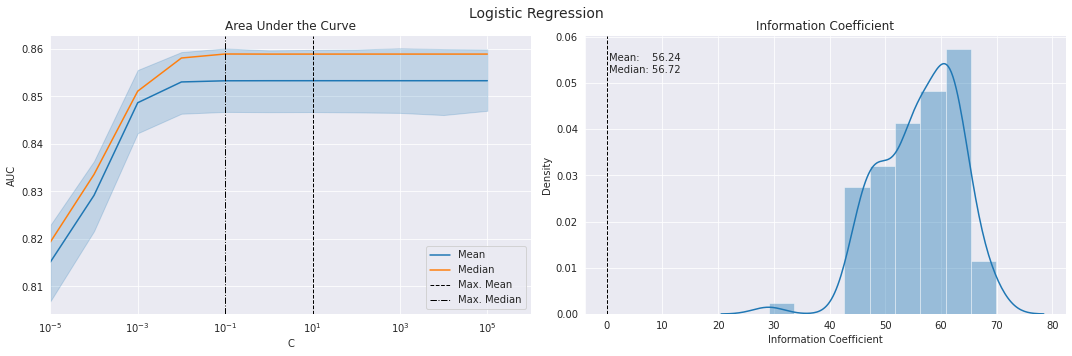

In [68]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);